# OpenAlex data for journals in the field of german law

## Table of content
* [Configure Notebook](#configure)
* [Intro](#Intro)
    * [General](#General)
    * [Specifications](#Specifications)
    * [Preparation](#Prep)
* [Items](#items)
    * [Item table](#item_table)
    * [Journal table](#journal_table)
* [Metadata](#metadata)
    * [Publication years](#pubyears)
    * [Authors & affiliations](#authors_and_affs)
        * [Authors](#authors)
        * [Affiliations](#affs)
    * [References & Citations](#refs_and_cits)
        * [References](#refs)
        * [Citations](#cits)
* [Classifications](#classifications)
* [Rankings](#rankings) 

Install and load JupySQL (https://jupysql.ploomber.io)

## <a id="configure"></a>Configure Notebook

In [5]:
%pip install jupysql python-dotenv --quiet
%load_ext sql
%config SqlMagic.displaylimit = 20
%load_ext autoreload
%pip install psycopg2-binary pandas matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.
The sql extension is already loaded. To reload it, use:
  %reload_ext sql
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 3.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Configure the sql adapter with your credentials. This requires an `.env` file having the following entries:
```
KB_HOST='<host name as as per KB instructions>'
KB_DB='<database name as per KB instructions>'
KB_PORT=<port as per KB instructions>
KB_USER='<Your user name>'
KB_PASS='<Your password>'
```

You also need to connect to the KB via VPN as per KB instructions.

In [6]:
from dotenv import load_dotenv
from sqlalchemy import URL, create_engine
import os
import pandas as pd
import matplotlib.pyplot as plt
load_dotenv('.env')
url = URL.create(
    "postgresql",
    host=os.environ['KB_HOST'],
    port=os.environ['KB_PORT'],
    database=os.environ['KB_DB'],
    username=os.environ['KB_USER'],
    password=os.environ['KB_PASS']
)
engine = create_engine(url)
%sql engine --alias kb_prod

Now you can run sql queries directly in the python notebook.

## <a id="Intro"></a> Intro

### <a id="General"></a> General

To run this notebook (preparation of tables for evaluations) you have to run the notebook evaluations_rewi_journal_lists first, as some of the resulting tables are used here. 
While in the other notebook we had a look at journal coverage, we now dive deeper into the OpenAlex data to evaluate the coverage on items level as well as metadata quality. 
For this we needed an item based gold standard with metadata information. We received some data directly from the publishers we use here. 
Evaluations until publication year 2023 (2023 included) - to change it change the parameter max_pubyear below. 
As this evaluation is done mailny on OpenAlex (simply because in the other sources we do not have enough content to evaluate), you can run it without having licensed Web of Science or Scopus (with very few exceptions).

### <a id="Specifications"></a>Specifications
To run this, you have to specify the version you want to use from the different sources. 
The vesion parameter specifies a suffix that is appended to all result tables. For Web of Science (wos) and Scopus (scp) the KB processes quarterly bibliometric databases in a specific schema. For OpenAlex, data is processed monthly. 

The parameters wos/scopus/openalex_bdb_schema have to be names of schemas in the PostgreSQL database following the KB data schema for bibliometric databases (todo: link zu zenodo veröffentlichung). The queries create tables in the given result schema. 

In [7]:
version_name = "202408"
result_schema = "project_rewi"
scp_bdb_schema = "scp_b_202407"
openalex_bdb_schema = "fiz_openalex_bdb_20240831_openbib"
openalex_rep_schema = "fiz_openalex_rep_20240831_openbib"
max_pubyear = 2023

### <a id="Prep"></a>Preparation: one table with all Publisherdata 

We received some data directly from publishers in different formats. This is combined here in one table. Join is done by  doi (already added to the single tables after the import), OpenAlex work type 'paratext' had to be excluded and doi matching had to be done case insensitive. 

In [18]:
%%sql
drop table if exists {{result_schema}}.eva_all_publisherdata_{{version_name}};
create table if not exists {{result_schema}}.eva_all_publisherdata_{{version_name}} as (
select 'AöR' as journal_name, 
a.doi, openalex_id, 
publishing_year as pubyear, b.pubyear as pubyear_openalex, 
case 
when first_authors is null then 0 
when first_authors is not null then length(first_authors) - length(replace(first_authors,',','')) + 1 
end as author_cnt,
coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_archiv_des_oeff_rechts a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where publishing_year <= {{max_pubyear}} 
union 
select 'AcP' as journal_name, 
a.doi, openalex_id, 
publishing_year as pubyear, b.pubyear as pubyear_openalex, 
case 
when first_authors is null then 0 
when first_authors is not null then length(first_authors) - length(replace(first_authors,',','')) + 1 
end as author_cnt,  
coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_archiv_fuer_civil_praxis a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where publishing_year <= {{max_pubyear}}  
union 
select 'Staat' as journal_name, 
a.doi, openalex_id, 
a.pubyear, b.pubyear as pubyear_openalex, 
author_cnt, coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_der_staat_items a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where a.pubyear <= {{max_pubyear}}  
union 
select 'JZ' as journal_name, 
a.doi, openalex_id, 
publishing_year as pubyear, b.pubyear as pubyear_openalex, 
case 
when first_authors is null then 0 
when first_authors is not null then length(first_authors) - length(replace(first_authors,',','')) + 1 
end as author_cnt,
coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_juristenzeitung a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where publishing_year <= {{max_pubyear}}  
union 
select 'KJ' as journal_name, 
a.doi, openalex_id, 
a.pubyear, b.pubyear as pubyear_openalex, 
author_cnt, coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_kj_items a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where a.pubyear <= {{max_pubyear}}  
union 
select 'KritV' as journal_name, 
a.doi, openalex_id, 
a.pubyear, b.pubyear as pubyear_openalex, 
author_cnt, coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_kritv_items a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where a.pubyear <= {{max_pubyear}}  
union 
select 'RabelsZ' as journal_name, 
a.doi, openalex_id, 
publishing_year as pubyear, b.pubyear as pubyear_openalex, 
case 
when first_authors is null then 0 
when first_authors is not null then length(first_authors) - length(replace(first_authors,',','')) + 1 
end as author_cnt,
coalesce(b.author_count,0) as author_cnt_openalex,
publisher, p.publisher_name as publisher_openalex, 
coalesce(inst_count,0) as inst_count_openalex, 
coalesce(cit_all_years_rep,0) as citations_count
from {{result_schema}}.jura_publisherdata_rabels a
left join {{openalex_bdb_schema}}.items b 
on a.openalex_id = b.item_id 
left join {{openalex_bdb_schema}}.publishers p
on b.publisher_id = p.publisher_id
where publishing_year <= {{max_pubyear}} );

Running query in 'kb_prod'

12380 rows affected.

++
||
++
++

In [11]:
%%sql
drop table if exists {{result_schema}}.ztab_inst_cnt_{{version_name}};
create table {{result_schema}}.ztab_inst_cnt_{{version_name}} as (
select work_id, count(distinct institution_id) as inst_cnt 
from {{openalex_rep_schema}}.works_authorships
where work_id in (select openalex_id from {{result_schema}}.eva_all_publisherdata_{{version_name}}) 
and institution_id is not null 
group by work_id);

update {{result_schema}}.eva_all_publisherdata_{{version_name}} a 
set inst_count_openalex = (select inst_cnt from {{result_schema}}.ztab_inst_cnt_{{version_name}} where a.openalex_id=work_id);

drop table {{result_schema}}.ztab_inst_cnt_{{version_name}};

Running query in 'kb_prod'

547 rows affected.

12379 rows affected.

++
||
++
++

## <a id="items"></a> Items

### <a id="items_table"></a>Table with all items in OpenAlex for journals in the gold standard (groels)

Based on the table {result_schema}.jura_groels_all_zeitschriften_{version_name}

In [12]:
%%sql
drop table if exists {{result_schema}}.eva_all_openalex_items_{{version_name}};
create table {{result_schema}}.eva_all_openalex_items_{{version_name}} as (
select distinct a.abk, c.* 
from (
select abk, unnest(issn_list) as sn from {{result_schema}}.jura_groels_alle_zeitschriften_{{version_name}}
) a
join {{openalex_bdb_schema}}.issn_isbn b 
on a.sn=b.sn 
join {{openalex_bdb_schema}}.items c 
on b.item_id = c.item_id 
where pubyear <= {{max_pubyear}} and not 'paratext' = any(item_type)
); 

alter table {{result_schema}}.eva_all_openalex_items_{{version_name}} add column in_openalex_but_not_in_publisherdata boolean; 

update {{result_schema}}.eva_all_openalex_items_{{version_name}} set in_openalex_but_not_in_publisherdata = true 
where abk in (select journal_name from {{result_schema}}.eva_all_publisherdata_{{version_name}})  
and not item_id in (select openalex_id from {{result_schema}}.eva_all_publisherdata_{{version_name}});

alter table {{result_schema}}.eva_all_openalex_items_{{version_name}} add column remark text;

Running query in 'kb_prod'

88794 rows affected.

++
||
++
++

Example for getting this table in a dataframe: 

In [11]:
df = pd.read_sql(f'select * from {result_schema}.eva_all_openalex_items_{version_name}', engine)

### <a id="journal_table"></a> Table with all journals in the gold standard

Contains additional information on journal basis for journals in OpenAlex that are in the gold standard.

In [13]:
%%sql
drop table if exists {{result_schema}}.eva_all_journals_{{version_name}};
create table {{result_schema}}.eva_all_journals_{{version_name}} as (
select a.zeitschrift, a.abk, 
a.in_wos, in_scp, in_openalex, in_crossref, 
min(pubyear) as min_pubyear_in_openalex, 
max(pubyear) as max_pubyear_in_openalex, 
count(distinct item_id) as num_articles_in_openalex,
sum(cit_all_years_rep) as sum_citations_for_all_articles_in_openalex
from 
(select zeitschrift, abk, 
case when wos_issn is not null then true else false end as in_wos, 
case when scp_issn is not null then true else false end as in_scp, 
case when openalex_source_id is not null then true else false end as in_openalex, 
case when crossref_issn is not null then true else false end as in_crossref 
from {{result_schema}}.jura_groels_alle_zeitschriften_{{version_name}}) a
left join {{result_schema}}.eva_all_openalex_items_{{version_name}} b 
on a.abk = b.abk 
group by a.zeitschrift, a.abk, a.in_wos, in_scp, in_openalex, in_crossref 
);

Running query in 'kb_prod'

51 rows affected.

++
||
++
++

How many items in the publisher data are missing in OpenAlex?

In [4]:
%%sql
select count(*)   
from {{result_schema}}.eva_all_publisherdata_{{version_name}} a 
where openalex_id is null

Running query in 'kb_prod'

1 rows affected.

count
67


Examples: Which items are missing in OpenAlex?

In [15]:
%%sql
select *  
from {{result_schema}}.eva_all_publisherdata_{{version_name}} a 
where openalex_id is null

Running query in 'kb_prod'

67 rows affected.

journal_name,doi,openalex_id,pubyear,pubyear_openalex,author_cnt,author_cnt_openalex,publisher,publisher_openalex,inst_count_openalex,citations_count
AcP,10.1628/acp-2022-0013,None,2022,None,2,0,Mohr Siebeck,None,None,0
AöR,10.1628/aoer-2022-0001,None,2022,None,1,0,Mohr Siebeck,None,None,0
AcP,10.1628/acp-2022-0017,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0353,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0354,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0398,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0388,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0338,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0382,None,2022,None,1,0,Mohr Siebeck,None,None,0
JZ,10.1628/jz-2022-0371,None,2022,None,1,0,Mohr Siebeck,None,None,0


In [8]:
%%sql
select journal_name, count(*)   
from {{result_schema}}.eva_all_publisherdata_{{version_name}} a 
where openalex_id is null 
group by journal_name

Running query in 'kb_prod'

6 rows affected.

journal_name,count
AcP,7
AöR,3
JZ,44
KJ,1
KritV,10
RabelsZ,2


Which items are in OpenAlex but missing in publisherdata (additional items in OpenAlex)? 

Overview: grouped by journal with minimal pubyear with additional items in OpenAlex and maximal pubyear with additional items in OpenAlex

In [14]:
%%sql
select abk, count(*), min(pubyear), max(pubyear) 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} 
where not lower(doi) in (select lower(doi) from {{result_schema}}.eva_all_publisherdata_{{version_name}}) 
and abk in (select journal_name from {{result_schema}}.eva_all_publisherdata_{{version_name}})
group by abk; 

Running query in 'kb_prod'

7 rows affected.

abk,count,min,max
RabelsZ,12,1977,2023
JZ,65,1997,2021
Staat,4,1977,2023
KJ,13,2018,2023
AcP,16,1976,2018
KritV,10,2023,2023
AöR,2,1993,2008


Todo: Question: why are they contained? One reason for older years could be that we do not have publisherdata for the old years (this would be ok) - but not for e.g. 2023 
For better evaluation: examles for a specific journal (usw parameter)

In [4]:
journal = 'KJ'

In [5]:
%%sql
select * 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} 
where not lower(doi) in (select lower(doi) from {{result_schema}}.eva_all_publisherdata_{{version_name}} ) 
and abk in (select journal_name from {{result_schema}}.eva_all_publisherdata_{{version_name}} )
and abk='{{journal}}'; 

Running query in 'kb_prod'

13 rows affected.

abk,item_id,pubyear,pubmonth,wos_pubdate_online,is_early_access,first_pubyear,item_title,scopus_item_title_non_eng,first_author,doi,pmid,source_title,scopus_source_id,book_series_title,scopus_issue_title,pages,first_page,last_page,article_number,volume,wos_special_issue,issue,source_type,item_type,prepublication_item,languages,publisher_id,inst_count,country_count,author_count,ref_count,source_ref_count,wos_aff_complete,german,vendor_pagecount,pagecount,wos_ci,keyword,class_name,cit_3_years,cit_5_years,cit_all_years,cit_all_years_rep,fncr_3_years,fncr_5_years,fncr_all_years,hc_3_years,hc_5_years,hc_all_years,oa_status,oa_url,scopus_oa_licence,wos_citation_context,in_openalex_but_not_in_publisherdata,remark
KJ,W2889712768,2018,1,None,None,None,Zwischen Humanität und Inhumanität: Aktuelle Herausforderungen im humanitären Völkerrecht,None,Andreas Fischer-Lescano,10.17176/20190103-134109-0,None,KJ / Kritische Justiz,None,None,None,367-375,367,375,None,51,None,3,journal,['article'],None,['de'],25756,None,None,1,None,0,None,False,None,9,None,['International Law'],['The Responsibility to Protect in International Relations'],0,0,0,0,0.0,0.0,0.0,"{""(\""The Responsibility to Protect in International Relations\"",0)""}","{""(\""The Responsibility to Protect in International Relations\"",0)""}","{""(\""The Responsibility to Protect in International Relations\"",0)""}",['closed'],None,None,None,None,None
KJ,W4390727498,2023,1,None,None,None,Familiennachzug zu subsidiär Schutzberechtigten Anmerkungen zu den Entscheidungen des Bundesverwaltungsgerichtes zu § 36a AufenthG,None,Julius Engel,10.5771/0023-4834-2023-4-458,None,KJ / Kritische Justiz,None,None,None,458-463,458,463,None,56,None,4,journal,['article'],None,['de'],25756,None,None,1,None,0,None,False,None,6,None,['Migration Law'],['Ethical and Legal Issues in Medicine'],0,0,0,0,0.0,0.0,0.0,"{""(\""Ethical and Legal Issues in Medicine\"",0.071423896)""}","{""(\""Ethical and Legal Issues in Medicine\"",0.071423896)""}","{""(\""Ethical and Legal Issues in Medicine\"",0.071423896)""}",['closed'],None,None,None,None,None
KJ,W4390749552,2023,1,None,None,None,Titelei/Inhaltsverzeichnis,None,None,10.5771/0023-4834-2023-4-381,None,KJ / Kritische Justiz,None,None,None,381-382,381,382,None,56,None,4,journal,['article'],None,['de'],25756,None,None,None,None,0,None,False,None,2,None,None,None,0,0,0,0,None,None,None,None,None,None,['closed'],None,None,None,None,None
KJ,W4390750594,2023,1,None,None,None,Urteil des Bundesverfassungsgerichts zur Gefangenenvergütung. Neue Vorgaben für den Niedriglohnsektor hinter Gittern,None,Florian Robbert,10.5771/0023-4834-2023-4-464,None,KJ / Kritische Justiz,None,None,None,464-470,464,470,None,56,None,4,journal,['article'],None,['de'],25756,None,None,1,None,0,None,False,None,7,None,None,['European Social Policy and Legal Framework'],0,0,0,0,0.0,0.0,0.0,"{""(\""European Social Policy and Legal Framework\"",0.04087591)""}","{""(\""European Social Policy and Legal Framework\"",0.04087591)""}","{""(\""European Social Policy and Legal Framework\"",0.04087591)""}",['closed'],None,None,None,None,None
KJ,W4390755416,2023,1,None,None,None,Gesellschaftsgestaltung und Kommunikation: Zum heutigen Selbstverständnis von Justizjurist:innen,None,Eva Kocher,10.5771/0023-4834-2023-4-442,None,KJ / Kritische Justiz,None,None,None,442-451,442,451,None,56,None,4,journal,['article'],None,['de'],25756,None,None,1,None,0,None,False,None,10,None,None,None,0,0,0,0,None,None,None,None,None,None,['closed'],None,None,None,None,None
KJ,W4390763560,2023,1,None,None,None,Landgericht Karlsruhe: Anklage gegen einen Journalisten wegen der Verlinkung einer verbotenen Webseite,None,Angela Furmaniak,10.5771/0023-4834-2023-4-452,None,KJ / Kritische Justiz,None,None,None,452-457,452,457,None,56,None,4,journal,['article'],None,['de'],25756,None,None,1,None,0,None,False,None,6,None,['Defamation'],['Legal Implications of Digital Technologies'],0,0,0,0,0.0,0.0,0.0,"{""(\""Legal Implications of Digital Technol

Timespan:

In [7]:
%%sql
select abk, pubyear, complete
from
(select abk, count(*), pubyear, 'less than 5 items' as complete
from {{result_schema}}.eva_all_openalex_items_{{version_name}}
group by abk, pubyear 
having count(*) < 5
union
select abk, count(*), pubyear, 'at least 5 items' as complete
from {{result_schema}}.eva_all_openalex_items_{{version_name}}
group by abk, pubyear
having count(*) >=5) 
order by abk, pubyear, complete

Running query in 'kb_prod'

1194 rows affected.

abk,pubyear,complete
AcP,1933,less than 5 items
AcP,1962,less than 5 items
AcP,1964,less than 5 items
AcP,1966,less than 5 items
AcP,1968,less than 5 items
AcP,1971,less than 5 items
AcP,1974,less than 5 items
AcP,1976,less than 5 items
AcP,1977,less than 5 items
AcP,1978,less than 5 items


## <a id="metadata"></a> Metadata

### <a id="authors_and_affs"></a>Authors and affiliations

In [16]:
%%sql
drop table if exists {{result_schema}}.eva_check_authors_affiliations_{{version_name}};
create table {{result_schema}}.eva_check_authors_affiliations_{{version_name}} as (
select b.author_id, c.display_name as author_name, b.institution_id, d.display_name as inst_name, 
count(distinct item_id) as num_articles, 
min(a.pubyear) as min_pubyear, 
max(a.pubyear) as max_pubyear, 
array_agg(a.abk) as journals
from {{result_schema}}.eva_all_openalex_items_{{version_name}} a  
join {{openalex_rep_schema}}.works_authorships b 
on a.item_id = b.work_id 
join {{openalex_rep_schema}}.authors c 
on b.author_id = c.id 
join {{openalex_rep_schema}}.institutions d 
on b.institution_id=d.id 
where author_id is not null and institution_id is not null 
group by b.author_id, c.display_name, b.institution_id, d.display_name);

Running query in 'kb_prod'

11568 rows affected.

++
||
++
++

#### <a id="authors"></a>Authors

Coverage: Number/percentage of publications having at least one author

In [5]:
%%sql
select round(100*count(*)/(select count(*) from {{result_schema}}.eva_all_openalex_items_{{version_name}})::decimal,2)
from {{result_schema}}.eva_all_openalex_items_{{version_name}} 
where item_id in (select work_id from {{openalex_rep_schema}}.works_authorships)

Running query in 'kb_prod'

1 rows affected.

round
69.43


Number of items in publisher data contained in OpenAlex as well without author in publisher data:

In [4]:
%%sql
select count(*) 
from {{result_schema}}.eva_all_publisherdata_{{version_name}} 
where author_cnt = 0 and openalex_id is not null

Running query in 'kb_prod'

1 rows affected.

count
3021


Number of items in publisher data set contained in OpenAlex as well whithout author in openalex:

In [5]:
%%sql
select count(*) 
from {{result_schema}}.eva_all_publisherdata_{{version_name}} 
where author_cnt_openalex = 0 and openalex_id is not null

Running query in 'kb_prod'

1 rows affected.

count
3319


Author differences with frequency over the whole dataset:

In [6]:
%%sql
drop table if exists {{result_schema}}.eva_author_cnt_comparison_{{version_name}};
create table {{result_schema}}.eva_author_cnt_comparison_{{version_name}} as (
select author_cnt_openalex - author_cnt as diff, count(*) as num_items
from  {{result_schema}}.eva_all_publisherdata_{{version_name}}
group by author_cnt_openalex - author_cnt 
order by author_cnt_openalex - author_cnt);

Running query in 'kb_prod'

29 rows affected.

++
||
++
++

In [13]:
%%sql
select * from {{result_schema}}.eva_author_cnt_comparison_{{version_name}}

Running query in 'kb_prod'

29 rows affected.

diff,num_items
-3,1
-2,18
-1,532
0,11663
1,43
2,6
3,11
4,10
5,3
6,12


Author differences and their frequency by journal: 

In [15]:
%%sql
drop table if exists {{result_schema}}.eva_author_cnt_comparison_mit_abk_{{version_name}};
create table {{result_schema}}.eva_author_cnt_comparison_mit_abk_{{version_name}} as (
 select journal_name, author_cnt_openalex - author_cnt as diff, count(*) as num_items
from {{result_schema}}.eva_all_publisherdata_{{version_name}} 
where openalex_id  is not null
group by journal_name, author_cnt_openalex - author_cnt 
order by journal_name, author_cnt_openalex - author_cnt
  ); 

Running query in 'kb_prod'

60 rows affected.

++
||
++
++

In [16]:
%%sql
select * from {{result_schema}}.eva_author_cnt_comparison_mit_abk_{{version_name}}

Running query in 'kb_prod'

60 rows affected.

journal_name,diff,num_items
AcP,-1,28
AcP,0,700
AcP,1,1
AöR,-1,39
AöR,0,879
AöR,1,2
JZ,-3,1
JZ,-2,12
JZ,-1,204
JZ,0,5426


In [19]:
dfx = pd.read_sql(f'select journal_name, diff, num_items as number_of_articles from {result_schema}.eva_author_cnt_comparison_mit_abk_{version_name}', engine)

In [22]:
print(dfx.keys())

Index(['journal_name', 'diff', 'number_of_articles'], dtype='object')


In [23]:
print(dfx)

   journal_name  diff  number_of_articles
0           AcP    -1                  28
1           AcP     0                 700
2           AcP     1                   1
3           AöR    -1                  39
4           AöR     0                 879
5           AöR     1                   2
6            JZ    -3                   1
7            JZ    -2                  12
8            JZ    -1                 204
9            JZ     0                5426
10           JZ     1                  18
11           JZ     2                   1
12           KJ    -2                   2
13           KJ    -1                 174
14           KJ     0                2278
15           KJ     1                  10
16           KJ     2                   4
17           KJ     3                   9
18           KJ     4                   9
19           KJ     5                   3
20           KJ     6                  12
21           KJ     7                   8
22           KJ     8             

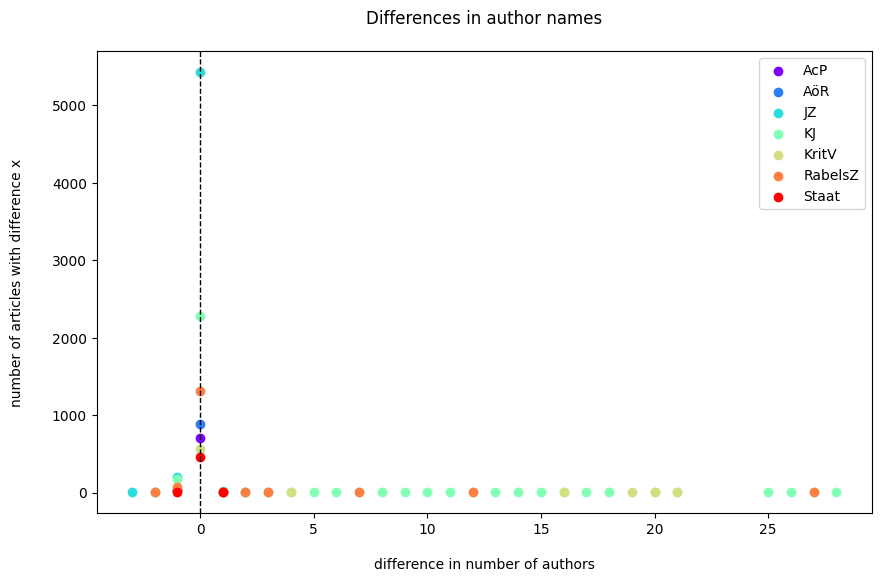

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.rainbow(np.linspace(0, 1, len(dfx['journal_name'].unique())))
color_dict = dict(zip(dfx['journal_name'].unique(), colors))
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

for name in dfx['journal_name'].unique():
    data = dfx[dfx['journal_name'] == name]
    ax.scatter(data['diff'], data['number_of_articles'], c=[color_dict[name]], label=name)

ax.set_xlabel('difference in number of authors')
ax.set_ylabel('number of articles with difference x')
ax.set_title('Differences in author names', pad=20)
plt.xlabel('difference in number of authors', labelpad=15)
plt.ylabel('number of articles with difference x', labelpad=20)

ax.legend()
plt.show()

#### <a id="affs"></a>Affiliations

How many items do have at least one institution assigned in OpenAlex?

In [4]:
%%sql
select count(distinct openalex_id) 
from {{result_schema}}.eva_all_publisherdata_{{version_name}} 
where openalex_id is not null;

Running query in 'kb_prod'

1 rows affected.

count
12312


In [6]:
%%sql
select count(distinct openalex_id)
from {{result_schema}}.eva_all_publisherdata_{{version_name}} 
where openalex_id is not null and author_cnt > 0

Running query in 'kb_prod'

1 rows affected.

count
9291


Items with cleaned affiliation data (at least one affiliation): 

In [13]:
%%sql
select count(distinct work_id)
from {{result_schema}}.eva_all_publisherdata_{{version_name}}  a
left join {{openalex_rep_schema}}.works_authorships b 
on a.openalex_id = b.work_id
where institution_id is not null

Running query in 'kb_prod'

RuntimeError: (psycopg2.OperationalError) could not translate host name "biblio-p-db03.fiz-karlsruhe.de" to address: Name or service not known

[SQL: select count(distinct work_id)
from project_rewi.eva_all_publisherdata_202408  a
left join fiz_openalex_rep_20240831_openbib_fdw.works_authorships b
on a.openalex_id = b.work_id
where institution_id is not null]
[parameters: [{}]]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


Items with affiliation data (also uncleaned)

In [ ]:
%%sql
select count(distinct work_id)
from {{result_schema}}.eva_all_publisherdata_{{version_name}}  a
left join {{openalex_rep_schema}}.works_authorships b 
on a.openalex_id = b.work_id
where institution_id is not null

Examples for uncleaned affiliation strings

In [ ]:
%%sql
select ord_id, raw_affiliation_string
from {{result_schema}}.eva_all_publisherdata_{{version_name}}  a
left join {{openalex_rep_schema}}.works_authorships b 
on a.openalex_id = b.work_id
where raw_affiliation_string is not null and institution_id is null 
limit 10

#### <a id="example_jz"></a>Example: Juristenzeitung

As an example we want to check authors and affiliations for the JZ: 

In [28]:
%%sql
drop table if exists {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}};
create table {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}} as (
select b.institution_id, b.raw_author_name, b.author_id, a2.display_name as cleaned_author_name, i.display_name as cleaned_institution_name, 
min(c.publication_year) as min_pubyear, max(publication_year) as max_pubyear, count(distinct b.work_id) as publ_cnt, max(b.work_id) as example_id
from {{openalex_rep_schema}}.works_locations a 
join {{openalex_rep_schema}}.works_authorships b 
on a.work_id = b.work_id 
join {{openalex_rep_schema}}.works c 
on c.id = b.work_id 
left join {{openalex_rep_schema}}.institutions i 
on b.institution_id = i.id 
left join {{openalex_rep_schema}}.authors a2 
on b.author_id = a2.id 
where a.source_id in (
select id 
from {{openalex_rep_schema}}.sources 
where issn_l in ('1868-7067','0022-6882'))
group by b.institution_id, b.raw_author_name, b.author_id, a2.display_name, i.display_name 
order by b.author_id, b.institution_id); 

Running query in 'kb_prod'

2405 rows affected.

++
||
++
++

Authors with most publications in the set first:

In [29]:
%%sql
select * 
from {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}} 
order by publ_cnt desc;

Running query in 'kb_prod'

2405 rows affected.

institution_id,raw_author_name,author_id,cleaned_author_name,cleaned_institution_name,min_pubyear,max_pubyear,publ_cnt,example_id
None,Herbert Roth,A5001329010,Herbert Roth,None,2005,2023,42,W462969622
None,Christian Starck,A5078526483,Christian Starck,None,2004,2021,29,W4248901624
None,Eric Hilgendorf,A5064136783,Eric Hilgendorf,None,2004,2024,24,W4396932684
None,Klaus Ferdinand Gärditz,A5080419284,Klaus Ferdinand Gärditz,None,2005,2024,24,W58054295
None,Friedrich-Christian Schroeder,A5027005631,Friedrich-Christian Schroeder,None,1989,2019,23,W96918939
None,Claus Dieter Classen,A5050947518,Claus Dieter Classen,None,2004,2023,22,W6535231
None,Bernd Rüthers,A5020569206,Bernd Rüthers,None,2004,2020,21,W82207161
None,Markus Winkler,A5023429731,Markus Winkler,None,2005,2024,20,W70160503
None,Christian Hillgruber,A5091383931,Christian Hillgruber,None,2004,2024,20,W956727680
None,Peter Mankowski,A5078554171,Peter Mankowski,None,2004,2019,19,W4256158665


Number of authors identified and cleaned in OpenAlex (means: with an id assigned, no evaluation on the quality of the cleaning so far):

In [31]:
%%sql
select count(distinct author_id) 
from {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}};

Running query in 'kb_prod'

1 rows affected.

count
2303


Thereof: authors with at least one affiliation assigned

In [32]:
%%sql
select count(distinct author_id) 
from {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}} 
where institution_id is not null;

Running query in 'kb_prod'

1 rows affected.

count
61


Authors that appear with as well as without affiliations assigned

In [34]:
%%sql
select count(distinct author_id) 
from {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}} 
where institution_id is not null
and author_id in (select author_id from {{result_schema}}.juristenzeitung_authors_affiliations_openalex_{{version_name}} where institution_id is null);

Running query in 'kb_prod'

1 rows affected.

count
34


This was a look at affiliations that had an id assigend in the data. Might be that there are raw affiliation strings but no institution id assigned in these cases, 
so a look at raw strings now: 

In [36]:
%%sql
select b.institution_id, b.raw_affiliation_string, b.raw_author_name, b.author_id, a2.display_name as cleaned_author_name, i.display_name as cleaned_institution_name, min(c.publication_year) as min_pubyear, max(publication_year) as max_pubyear, count(distinct b.work_id) as publ_cnt, max(b.work_id) as example_id
from {{openalex_rep_schema}}.works_locations a 
join {{openalex_rep_schema}}.works_authorships b 
on a.work_id = b.work_id 
join {{openalex_rep_schema}}.works c 
on c.id = b.work_id 
left join {{openalex_rep_schema}}.institutions i 
on b.institution_id = i.id 
left join {{openalex_rep_schema}}.authors a2 
on b.author_id = a2.id 
where a.source_id in (
select id 
from {{openalex_rep_schema}}.sources 
where issn_l in ('1868-7067','0022-6882')) and institution_id is null and raw_affiliation_string is not null
group by b.institution_id, b.raw_affiliation_string , b.raw_author_name, b.author_id, a2.display_name, i.display_name 
order by b.author_id, b.institution_id

Running query in 'kb_prod'

51 rows affected.

institution_id,raw_affiliation_string,raw_author_name,author_id,cleaned_author_name,cleaned_institution_name,min_pubyear,max_pubyear,publ_cnt,example_id
None,Law,Kyriakos Kotsoglou,A5001465745,Kyriakos N. Kotsoglou,None,2014,2014,1,W3194901151
None,Eigentumsgesetzgebung im Lichte des Grundgesetzes und der Europäischen Menschenrechtskonvention Ein Beitrag zum Eigentumsschutz im europäischen Grundrechtsverbund -,Fabian Michl,A5003040578,Fabian Michl,None,2013,2013,1,W2063807037
None,Haftung des Arztes bei fehlerhafter,Fabian Michl,A5003040578,Fabian Michl,None,2013,2013,1,W2063807037
None,zu diesem Verbund selbstredend auch den,Fabian Michl,A5003040578,Fabian Michl,None,2013,2013,1,W2063807037
None,"auf einem Vortrag, der an den Universitäten in Washington, Chicago und Johannesburg gehalten wurde.",Thomas M.J. Möllers,A5003190047,Thomas M. J. Möllers,None,2009,2009,1,W2054059995
None,Das neue europäische und amerikanische Recht -Wichtige,Thomas M.J. Möllers,A5003190047,Thomas M. J. Möllers,None,2009,2009,1,W2054059995
None,Die Rolle des Rechts im Rahmen der Europäischen Inte,Thomas M.J. Möllers,A5003190047,Thomas M. J. Möllers,None,2009,2009,1,W1994933201
None,Lehrstuhl.,Thomas M.J. Möllers,A5003190047,Thomas M. J. Möllers,None,2012,2012,1,W2045065005
None,"Wirtschaftsrecht, Euro-parecht, Internationales Privatrecht und Rechtsvergleichung an der Univer-sität Augsburg und ist Inhaber eines Jean-Monnet-ad-personam-Lehrstuhls sowie geschäftsführender Direktor des Center for European Legal Studies (CELOS). Sabrina Hailer ist wissenschaftliche Mitarbeiterin an diesem",Thomas M.J. Möllers,A5003190047,Thomas M. J. Möllers,None,2012,2012,1,W2045065005
None,"Department I, Max Planck Institute Luxembourg, Max Planck Society",Burkhard Hess,A5003851944,Burkhard Heß,None,2012,2014,2,W2054430390


(For already processed versions there was not really a big amount of institutions with sensible raw affiliation string but without institution id assigned.)

Function for counting authors for a given work_id

In [37]:
%%sql
CREATE OR REPLACE FUNCTION {{result_schema}}.count_authors(schema_name TEXT, work_id TEXT)
RETURNS INTEGER AS $$
DECLARE
    result INTEGER;
    query TEXT;
BEGIN
    query := format('SELECT COUNT(distinct author_id) FROM %I.works_authorships WHERE work_id = $1', schema_name);
    
    EXECUTE query INTO result USING work_id;
    
    RETURN result;
END;
$$
 LANGUAGE plpgsql;

Running query in 'kb_prod'

++
||
++
++

Example usage

In [38]:
%%sql
select doi, title, author_cnt, {{result_schema}}.count_authors('{{openalex_rep_schema}}', openalex_id) 
from {{result_schema}}.jura_publisherdata_der_staat_items jpdsi;

Running query in 'kb_prod'

472 rows affected.

doi,title,author_cnt,count_authors
10.3790/staa.62.2.243,Geld und europäisches Verfassungsrecht. Institutionelle Wertesicherung durch Zwangsgelder in der Europäischen Union,1,1
10.3790/staa.52.3.371,Doppelstandards des Bundesverfassungsgerichts beim Schutz europäischer Grundrechte,1,1
10.3790/staa.48.2.305,Buchbesprechungen und Buchanzeigen,0,0
10.3790/staa.51.3.357,EUROPAS WIRTSCHAFTSVERFASSUNG IN DER KRISE,1,1
10.3790/staa.59.4.489,Gespräche mit Hegel,1,1
10.3790/staa.57.4.toc,Inhalt,0,0
10.3790/staa.53.2.331,Verfassungsanalyse und Verfassungskritik. Die ungarische Verfassung im Spiegel zweier Neuerscheinungen,2,2
10.3790/staa.52.1.99,Werte und Normen im Recht. Hans Kelsen und die weltanschauliche Neutralität des Staates,1,1
10.3790/staa.57.3.387,Die beste aller schlechten Lösungen. Plädoyer für eine Ausweitung der staatlichen Parteienfinanzierung,1,1
10.3790/staa.59.3.421,Von Repräsentation zu demokratischer Gleichheit,1,1


### <a id="pubyears"></a>Publication years

Coverage of publication years in the whole set of articles of journals in the gold standard journals:

In [13]:
%%sql
select count(*) 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} 
where pubyear is null

Running query in 'kb_prod'

1 rows affected.

count
0


In [14]:
%%sql
drop table if exists {{result_schema}}.eva_pubyear_comparison_{{version_name}};
create table {{result_schema}}.eva_pubyear_comparison_{{version_name}} as (
select a.journal_name as abk, a.pubyear, 
a.num_articles as num_articles_publisher, coalesce(b.num_articles,0) as num_articles_openalex, 
a.num_articles - coalesce(b.num_articles,0) as diff
from 
(select journal_name, pubyear, count(distinct doi) as num_articles 
from {{result_schema}}.eva_all_publisherdata_{{version_name}}
group by journal_name, pubyear) as a 
left join 
(select abk, pubyear, count(distinct item_id) as num_articles
from {{result_schema}}.eva_all_openalex_items_{{version_name}} 
group by abk, pubyear
) as b 
on a.journal_name = b.abk and a.pubyear = b.pubyear 
order by a.journal_name, a.pubyear
);

Running query in 'kb_prod'

176 rows affected.

++
||
++
++

Differences in publication years

More items for a specific publication year in OpenAlex

In [40]:
%%sql
select * 
from {{result_schema}}.eva_pubyear_comparison_{{version_name}} 
where diff < 0;

Running query in 'kb_prod'

68 rows affected.

abk,pubyear,num_articles_publisher,num_articles_openalex,diff
AcP,2006,25,26,-1
AcP,2008,25,31,-6
AcP,2010,29,30,-1
AcP,2011,26,27,-1
AcP,2012,33,38,-5
AcP,2015,24,25,-1
AcP,2016,53,56,-3
AcP,2017,34,35,-1
AcP,2018,62,66,-4
AöR,2005,28,29,-1


Less items for a specific publication year in OpenAlex

In [41]:
%%sql
select * 
from {{result_schema}}.eva_pubyear_comparison_{{version_name}}  
where diff > 0;

Running query in 'kb_prod'

23 rows affected.

abk,pubyear,num_articles_publisher,num_articles_openalex,diff
AcP,2022,36,29,7
AöR,2022,28,25,3
JZ,2013,263,255,8
JZ,2020,386,385,1
JZ,2022,385,347,38
JZ,2023,363,360,3
KJ,2002,38,37,1
KJ,2007,42,36,6
KJ,2009,48,38,10
KJ,2019,76,60,16


Frequency of difference cases by journal

In [15]:
%%sql
select journal_name, count(*)  
from {{result_schema}}.eva_all_publisherdata_{{version_name}}   a 
where a.pubyear <> a.pubyear_openalex 
group by journal_name 
order by count(*) desc;

Running query in 'kb_prod'

4 rows affected.

journal_name,count
KritV,180
RabelsZ,86
KJ,33
JZ,12


Examples of items with different publication years in OpenAlex and publisherdata 
todo: maybe some manual checks which pubyear is correct and why they differ? (early access??)

In [6]:
%%sql
select *  
from {{result_schema}}.eva_all_publisherdata_{{version_name}}   a 
where a.pubyear <> a.pubyear_openalex 
order by random()
limit 10;

Running query in 'kb_prod'

10 rows affected.

journal_name,doi,openalex_id,pubyear,pubyear_openalex,author_cnt,author_cnt_openalex,publisher,publisher_openalex,inst_count_openalex,citations_count
RabelsZ,10.1628/003372514X683657,W2520739598,2014,2018,1,1,Mohr Siebeck,Mohr Siebeck Verlag,None,0
RabelsZ,10.1628/rabelsz-2023-0039,W4367355386,2023,2024,1,1,Mohr Siebeck,Mohr Siebeck Verlag,None,0
KritV,10.5771/2193-7869-2017-3-217,W2783831291,2018,2017,1,1,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,0
KritV,10.5771/2193-7869-2015-4-430,W2409900970,2016,2015,1,1,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,4
KritV,10.5771/2193-7869-2017-3-198,W4252335343,2018,2017,0,0,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,0
RabelsZ,10.1628/0033725024123107,W2027006542,2002,2018,1,1,Mohr Siebeck,Mohr Siebeck Verlag,2,1
KritV,10.5771/2193-7869-2008-4-489,W4247440299,2009,2008,1,1,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,2
KritV,10.5771/2193-7869-2008-4-360,W2325741554,2009,2008,1,1,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,0
KritV,10.5771/2193-7869-2019-3-187,W3003520399,2020,2019,1,1,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,0
KritV,10.5771/2193-7869-2017-4-309,W2793767169,2018,2017,1,1,Nomos Verlagsgesellschaft mbH & Co. KG,Nomos,None,0


In [6]:
%%sql
select pubyear-pubyear_openalex as diff, count(*) as number_of_items  
from {{result_schema}}.eva_all_publisherdata_{{version_name}}   a 
    where openalex_id is not null
group by pubyear-pubyear_openalex
order by pubyear-pubyear_openalex

Running query in 'kb_prod'

6 rows affected.

diff,number_of_items
-16,21
-5,12
-4,22
-1,43
0,12001
1,213


In [23]:
%%sql
select journal_name, pubyear-pubyear_openalex as diff, count(*)   as number_of_articles
from {{result_schema}}.eva_all_publisherdata_{{version_name}}   a 
    where openalex_id is not null
group by  journal_name, pubyear-pubyear_openalex
order by  journal_name, pubyear-pubyear_openalex

Running query in 'kb_prod'

13 rows affected.

journal_name,diff,number_of_articles
AcP,0,729
AöR,0,920
JZ,-5,12
JZ,0,5650
KJ,0,2538
KJ,1,33
KritV,0,400
KritV,1,180
RabelsZ,-16,21
RabelsZ,-4,22


In [26]:
%%sql
select doi, openalex_id, pubyear, pubyear_openalex
from {{result_schema}}.eva_all_publisherdata_{{version_name}}   a 
where openalex_id is not null and journal_name='JZ' and pubyear <> pubyear_openalex

Running query in 'kb_prod'

12 rows affected.

doi,openalex_id,pubyear,pubyear_openalex
10.1628/002268813X13692360378066,W4256467195,2013,2018
10.1628/002268813X13642197143531,W2085189924,2013,2018
10.1628/002268813X13618701755457,W1969212467,2013,2018
10.1628/002268813X13662821332580,W1980096331,2013,2018
10.1628/002268813X13693879459600,W2075325565,2013,2018
10.1628/002268813X13687864605420,W2033145082,2013,2018
10.1628/002268813X13693789312666,W4244831878,2013,2018
10.1628/002268813X13703519576599,W4240434596,2013,2018
10.1628/002268813X13603225007326,W1998382653,2013,2018
10.1628/002268813X13703519576634,W4241916714,2013,2018


### <a id="refs_and_cits"></a> References & citations

This section contains evaluations concerning references and citations. As we do not have them in the publisher data, we cannot do comparisones here.

Furthermore, it is quite impossible to get gold standard data on citations at all. 
As a little experiment, we look for the appearance of one journal (JZ) in the references of Scopus: if the journal appears in a reference of an article in Scopus, 
it is a citation for this journal. The number of articles having the journal in the references can be seen as lower threshold for the 'real' number of citations. 

#### <a id="refs"></a>References: an item in the reference list of an article in a journal in the gold standard set

Table with the number references of articles of journals in the gold standard. (The citing item is the publication mentioned in the reference list of the cited item)

In [43]:
%%sql 
drop table if exists {{result_schema}}.eva_refs_in_openalex_{{version_name}};
create table {{result_schema}}.eva_refs_in_openalex_{{version_name}} as (
select a.abk, a.pubyear, a.item_id, r.item_id_cited, r.citing_pubyear, r.ref_pubyear
from {{result_schema}}.eva_all_openalex_items_{{version_name}} a 
left join {{openalex_bdb_schema}}.refs r 
on a.item_id = r.item_id_citing 
order by a.abk, a.pubyear
);

Running query in 'kb_prod'

91743 rows affected.

++
||
++
++

Aggregation: count number of refs by journal and pubyear. Each reference is counted (so if two articles have the same referenced article it is counted twice).

In [44]:
%%sql
drop table if exists {{result_schema}}.eva_refs_in_openalex_agg_{{version_name}};
create table {{result_schema}}.eva_refs_in_openalex_agg_{{version_name}} as (
select abk, pubyear, count(*) 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}}
where item_id_cited is not null 
group by abk, pubyear);

Running query in 'kb_prod'

278 rows affected.

++
||
++
++

#### Percentage of articles in the set that have at least one reference: 

In [67]:
%%sql
select round(100*
(select count(distinct item_id) 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} eaoi 
where item_id in (select item_id from {{result_schema}}.eva_refs_in_openalex_{{version_name}} where item_id_cited is not null))
/
(select count(distinct item_id) from {{result_schema}}.eva_all_openalex_items_{{version_name}})::decimal,2)

Running query in 'kb_prod'

1 rows affected.

round
2.72


#### Percentage of articles in the set that have at least one reference:

In [23]:
%%sql
select b.abk, round(100*coalesce(with_ref,0)/total::decimal ,2) as share_with_ref
    from 
(select abk, count(distinct item_id) as with_ref
from {{result_schema}}.eva_all_openalex_items_{{version_name}} eaoi 
where item_id in (select item_id from {{result_schema}}.eva_refs_in_openalex_{{version_name}} where item_id_cited is not null)
group by abk) a
right join
(select abk, count(distinct item_id) as total from {{result_schema}}.eva_all_openalex_items_{{version_name}} group by abk) b
    on a.abk = b.abk

Running query in 'kb_prod'

31 rows affected.

abk,share_with_ref
AcP,0.57
AG,0.20
AöR,0.00
AVR,0.66
BB,0.00
CR,0.11
DVBI,0.00
EuR,2.63
GmbHR,0.00
JR,0.09


Visualization share of articles with references per journal

In [25]:
df = pd.read_sql(f'''select b.abk, round(100*coalesce(with_ref,0)/total::decimal ,2) as share_with_ref
    from 
(select abk, count(distinct item_id) as with_ref
from {result_schema}.eva_all_openalex_items_{version_name} eaoi 
where item_id in (select item_id from {result_schema}.eva_refs_in_openalex_{version_name} where item_id_cited is not null)
group by abk) a
right join
(select abk, count(distinct item_id) as total from {result_schema}.eva_all_openalex_items_{version_name} group by abk) b
    on a.abk = b.abk''',engine)

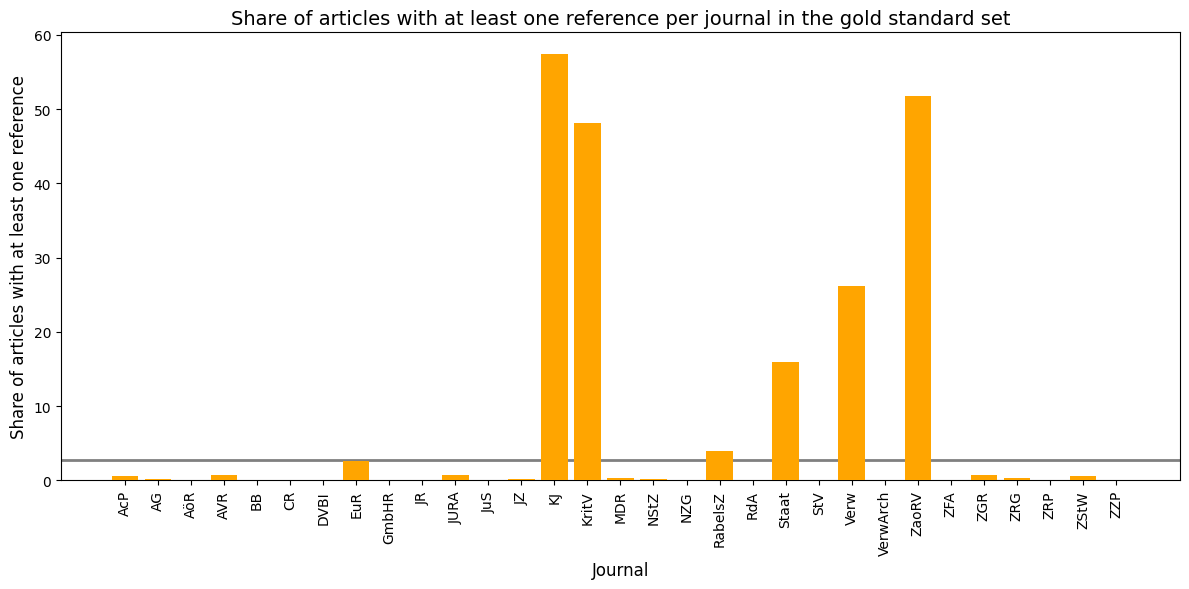

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.axhline(y=2.72, color='gray', linewidth=2, zorder=0)
bars = plt.bar(df['abk'], df['share_with_ref'], color='orange', zorder=3)

# X-Achse anpassen
plt.xlabel('Journal', fontsize=12)
plt.xticks(rotation=90, ha='center')

# Y-Achse anpassen
plt.ylabel('Share of articles with at least one reference', fontsize=12)

# Titel hinzufügen
plt.title('Share of articles with at least one reference per journal in the gold standard set', fontsize=14)

# Layout optimieren
plt.tight_layout()

# Diagramm anzeigen
plt.show()


Same grouped by pubyear (to see if situation is better for more recent years):

In [71]:
%%sql
select a.pubyear, total, with_refs, round(100*with_refs/total::decimal,2) as with_refs_percent 
from 
(select pubyear, count(distinct item_id) as total
from {{result_schema}}.eva_all_openalex_items_{{version_name}}
group by pubyear) a
left join 
(select pubyear, count(distinct item_id) as with_refs 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} eaoi 
where item_id in (select item_id from {{result_schema}}.eva_refs_in_openalex_{{version_name}} where item_id_cited is not null)
group by pubyear) b
on a.pubyear=b.pubyear 
order by a.pubyear desc, total, with_refs

Running query in 'kb_prod'

153 rows affected.

pubyear,total,with_refs,with_refs_percent
2023,3828,57,1.49
2022,3988,48,1.20
2021,4090,65,1.59
2020,3897,47,1.21
2019,4036,50,1.24
2018,3420,51,1.49
2017,3325,40,1.20
2016,3225,58,1.80
2015,2739,49,1.79
2014,1969,91,4.62


---- The following queries are additional, not mentioned in the article  ... (?) ---> todo: nochmal ansehen und evtl aussortieren

Now we want to have a look at the (rare) references: we would expect that articles of journals in the gold standard set reference articles that are also in the gold standard set 
or at least classified as 'german law article' in OpenAlex.

Add a flag, to identify references to articles that are also articles in journals in the gold standard. We would expect this number to be quite high as we expect 
german law articles to cite german law articles.

In [58]:
%%sql
alter table {{result_schema}}.eva_refs_in_openalex_{{version_name}} add column if not exists ref_is_also_in_goldstandard boolean;
update {{result_schema}}.eva_refs_in_openalex_{{version_name}} set ref_is_also_in_goldstandard = null where item_id_cited is null;
update {{result_schema}}.eva_refs_in_openalex_{{version_name}} set ref_is_also_in_goldstandard = false where item_id_cited is not null;
update {{result_schema}}.eva_refs_in_openalex_{{version_name}} set ref_is_also_in_goldstandard = true where item_id_cited in (select item_id from {{result_schema}}.eva_all_openalex_items_{{version_name}});

Running query in 'kb_prod'

86377 rows affected.

5366 rows affected.

2222 rows affected.

++
||
++
++

How many distinct publications are cited by articles from journals in the gold standard set?

In [7]:
%%sql
select count(distinct item_id_cited) 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
where item_id_cited is not null

Running query in 'kb_prod'

1 rows affected.

count
5097


In [ ]:
What amount of references is also contained in the gold standard set? 

In [6]:
%%sql
select round(100*
(select count(distinct item_id_cited) 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
where item_id_cited is not null and ref_is_also_in_goldstandard is true)/
(select count(distinct item_id_cited) 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
where item_id_cited is not null)::decimal,2)

Running query in 'kb_prod'

1 rows affected.

round
41.55


Have a look at some references that are not in the gold standard set: 

In [60]:
%%sql
select * 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
where ref_is_also_in_goldstandard is false;

Running query in 'kb_prod'

3144 rows affected.

abk,pubyear,item_id,item_id_cited,citing_pubyear,ref_pubyear,ref_is_also_in_goldstandard,ref_is_also_german_law
AcP,2008,W2319275960,W2976017600,2008,2019,False,False
AcP,2008,W2319275960,W1551134357,2008,1982,False,False
AcP,2008,W2319275960,W123370347,2008,1993,False,False
AcP,2008,W2319275960,W4214567421,2008,1996,False,False
AcP,2008,W2319275960,W2796459451,2008,1967,False,False
AcP,2008,W2022878688,W1586983768,2008,2002,False,False
AcP,2010,W1972485205,W2038824064,2010,1992,False,False
AcP,2010,W1972485205,W755717800,2010,2003,False,False
AcP,2010,W1972485205,W815446541,2010,2005,False,False
AcP,2011,W1982152781,W2221889183,2011,2015,False,False


Are these articles that are considered as german law in OpenAlex (in journals from the trivial search result)? 

In [12]:
%%sql
alter table {{result_schema}}.eva_refs_in_openalex_{{version_name}} add column if not exists ref_is_also_german_law boolean;
update {{result_schema}}.eva_refs_in_openalex_{{version_name}} set ref_is_also_german_law = null where item_id_cited is null;
update {{result_schema}}.eva_refs_in_openalex_{{version_name}} set ref_is_also_german_law = false where item_id_cited is not null;
update {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
    set ref_is_also_german_law = true 
where item_id_cited in (
    select work_id 
from {{openalex_rep_schema}}.works_locations 
where source_id in 
(select id  
from {{openalex_rep_schema}}.sources s 
where id in (select source_id from {{result_schema}}.eva_openalex_de_law_journals_trivial_search_result_{{version_name}} where source_id is not null)));

Running query in 'kb_prod'

86377 rows affected.

5366 rows affected.

2311 rows affected.

++
||
++
++

How many articles are at least in the journal list we retrieved with trivial search (german, law) in OpenAlex (even though they might be not in our gold standard set)? 

In [13]:
%%sql
select round(100*
(select count(distinct item_id_cited) 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
where item_id_cited is not null and ref_is_also_german_law is true)/
(select count(distinct item_id_cited) 
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} 
where item_id_cited is not null)::decimal,2)

Running query in 'kb_prod'

1 rows affected.

round
43.24


Have a look at referenced articles that are neither in the gold standard nor considered as german law articles in OpenAlex. 
What kind of articles?? Maybe additional evaluation on their keywords?

In [15]:
%%sql
select a.*, b.doi as cited_doi, b.class_name as cited_class, b.keyword as cited_keyword, b.source_title as cited_source  
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} a 
    join {{openalex_bdb_schema}}.items b 
    on a.item_id_cited = b.item_id 
where ref_is_also_german_law is false
    limit 5;

Running query in 'kb_prod'

5 rows affected.

abk,pubyear,item_id,item_id_cited,citing_pubyear,ref_pubyear,ref_is_also_in_goldstandard,ref_is_also_german_law,cited_doi,cited_class,cited_keyword,cited_source
AcP,2008,W2319275960,W2976017600,2008,2019,False,False,10.1628/978-3-16-157866-3,['Imperialism and Global Capitalism Critique'],"['Behavioral Economics', 'Consumer Policy', 'Ethical Consumption', 'Sustainable Consumption', 'Verbraucherpolitik']",Mohr Siebeck eBooks
AcP,2008,W2319275960,W1551134357,2008,1982,False,False,10.1016/0378-4266(82)90040-1,['Value-based Management and Economic Performance Measurement'],"['Capital Budgeting', 'Corporate finance', 'Corporate Governance', 'Corporate Valuation', 'Dividend Policy', 'Financial Performance']",Journal of Banking & Finance
AcP,2008,W2319275960,W123370347,2008,1993,False,False,10.2307/2328900,['Global Bankruptcy Law and Financial Distress'],"['Company Governance', 'Corporate Governance', 'Corporate Law Arbitrage', 'Corporate Mobility', 'European Company Law']",The Journal of Finance
AcP,2008,W2319275960,W4214567421,2008,1996,False,False,10.1007/978-3-322-86649-3,['Causes and Consequences of Eurozone Financial Crisis'],"['European Stability Mechanism', 'Investment Decisions', 'Liquidity', 'Monetary Policy Instruments', 'Supply Chain Controlling']",Gabler Verlag eBooks
AcP,2008,W2319275960,W2796459451,2008,1967,False,False,10.2307/2978923,['Asset Pricing and Market Efficiency'],"['Asset Pricing', 'Behavioral Finance', 'Insider trading', 'Investor Sentiment', 'Network Marketing', 'Stock Returns']",The Journal of Finance


#### Journals

In [ ]:
Journals in which the references are published that are not in german law journals (considering the trivial search list):

In [19]:
%%sql
--- journals
drop table if exists {{result_schema}}.eva_refs_journals_{{version_name}};
create table {{result_schema}}.eva_refs_journals_{{version_name}} as (
select c.display_name as journal_title, count(distinct item_id_cited) as item_cnt
from {{result_schema}}.eva_refs_in_openalex_{{version_name}} a 
join {{openalex_rep_schema}}.works_primary_locations b
on a.item_id_cited = b.work_id 
join {{openalex_rep_schema}}.sources c 
on b.source_id = c.id 
where a.ref_is_also_german_law is false 
and a.ref_is_also_in_goldstandard is false 
group by c.display_name);

Running query in 'kb_prod'

923 rows affected.

++
||
++
++

#### Journals in which the references are published that are not in german law journals with number of publications: 

List of German Law Journals based on the trivial search result

In [20]:
%%sql
select * 
from {{result_schema}}.eva_refs_journals_{{version_name}} 
order by item_cnt desc

Running query in 'kb_prod'

923 rows affected.

journal_title,item_cnt
SSRN Electronic Journal,116
Mohr Siebeck eBooks,77
Oxford University Press eBooks,72
Springer eBooks,65
De Gruyter eBooks,64
VS Verlag für Sozialwissenschaften eBooks,42
Routledge eBooks,38
Choice Reviews Online,31
Cambridge University Press eBooks,28
Nomos Verlagsgesellschaft mbH & Co. KG eBooks,27


What types have these sources? (maybe they are not journals?)

In [22]:
%%sql
    select type, count(*) 
    from {{openalex_rep_schema}}.sources
where display_name in (
    select journal_title 
from {{result_schema}}.eva_refs_journals_{{version_name}} ) 
group by type

Running query in 'kb_prod'

6 rows affected.

type,count
repository,15
conference,1
ebook platform,235
journal,693
book series,29
other,1


Only the ones that are journals: 

In [25]:
%%sql
select * 
from {{result_schema}}.eva_refs_journals_{{version_name}} 
where journal_title in (select display_name from {{openalex_rep_schema}}.sources where type='journal') 
order by item_cnt desc

Running query in 'kb_prod'

642 rows affected.

journal_title,item_cnt
Choice Reviews Online,31
European Journal of International Law,19
American Journal of International Law,19
International Affairs,17
The American Journal of Comparative Law,16
European Law Journal,13
International Journal of Constitutional Law,12
Foreign Affairs,12
The Yale Law Journal,12
The American Historical Review,11


### <a id="cits"></a> Citations: an (arbitrary) article has an article of the gold standard journals in the reference list

Table with all citations on gold standard articles 

In [115]:
%%sql
drop table if exists {{result_schema}}.eva_citations_in_openalex_{{version_name}};
create table {{result_schema}}.eva_citations_in_openalex_{{version_name}} as (
select a.abk, a.pubyear, r.item_id_citing, a.item_id, r.citing_pubyear, r.ref_pubyear
from {{result_schema}}.eva_all_openalex_items_{{version_name}} a 
left join {{openalex_bdb_schema}}.refs r 
on a.item_id = r.item_id_cited 
order by a.abk, a.pubyear
);
commit;

Running query in 'kb_prod'

130637 rows affected.

++
||
++
++

Share of articles in the gold standard set that have at least one citation: 

In [29]:
%%sql
select round(100*
(select count(distinct item_id) 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} eaoi 
where item_id in (select item_id from {{result_schema}}.eva_citations_in_openalex_{{version_name}} where item_id_citing is not null))
/
(select count(distinct item_id) from {{result_schema}}.eva_all_openalex_items_{{version_name}})::decimal,2)

Running query in 'kb_prod'

1 rows affected.

round
18.16


Share of articles per journal in the gold standard set that have at least one citation: 

In [17]:
%%sql
select a.abk, round(100*coalesce(cnt_with_cit,0)/cnt_total::decimal,2) as share_with_cit
from 
(select abk, count(distinct item_id) as cnt_with_cit
from {{result_schema}}.eva_all_openalex_items_{{version_name}} eaoi 
where item_id in (select item_id from {{result_schema}}.eva_citations_in_openalex_{{version_name}} where item_id_citing is not null)
    group by abk) a 
right join 
(select abk, count(distinct item_id) as cnt_total from {{result_schema}}.eva_all_openalex_items_{{version_name}} group by abk) b
on a.abk=b.abk
order by  round(100*coalesce(cnt_with_cit,0)/cnt_total::decimal,2) desc

Running query in 'kb_prod'

31 rows affected.

abk,share_with_cit
KJ,66.99
KritV,56.88
AVR,43.12
Staat,41.49
EuR,40.62
Verw,36.55
ZGR,34.55
ZaoRV,32.94
NStZ,31.98
AöR,31.95


In [18]:
df = pd.read_sql(f'''select a.abk, round(100*coalesce(cnt_with_cit,0)/cnt_total::decimal,2) as share_with_cit
from 
(select abk, count(distinct item_id) as cnt_with_cit
from {result_schema}.eva_all_openalex_items_{version_name} eaoi 
where item_id in (select item_id from {result_schema}.eva_citations_in_openalex_{version_name} where item_id_citing is not null)
    group by abk) a 
right join 
(select abk, count(distinct item_id) as cnt_total from {result_schema}.eva_all_openalex_items_{version_name} group by abk) b
on a.abk=b.abk
order by  round(100*coalesce(cnt_with_cit,0)/cnt_total::decimal,2) desc''',engine)

Visualization share of articles with at least one citation per journal

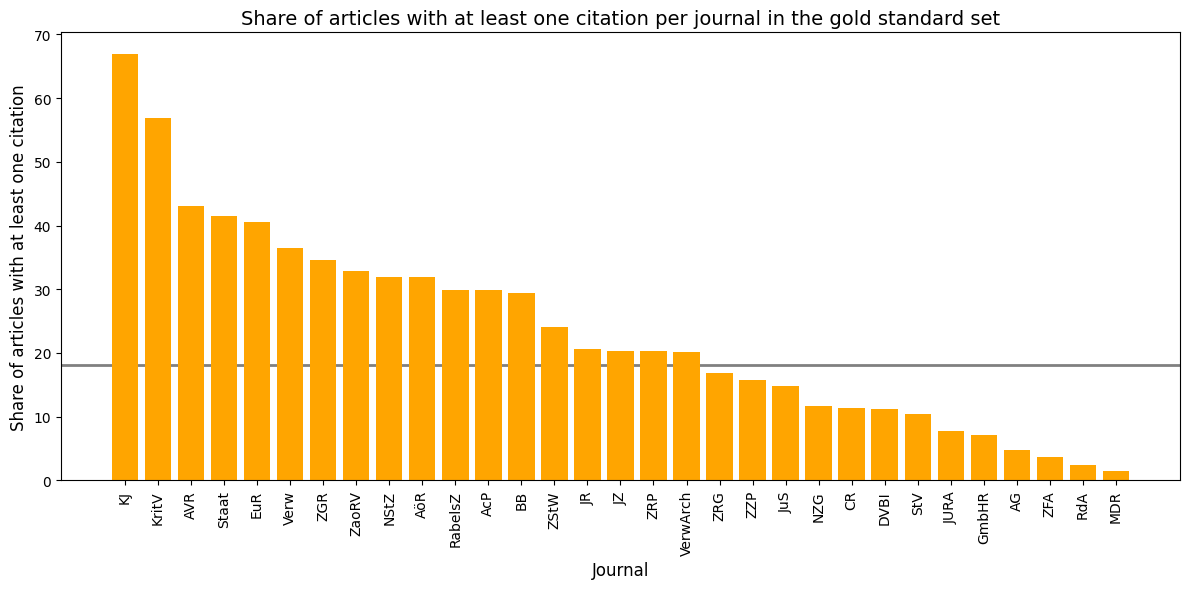

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bars = plt.bar(df['abk'], df['share_with_cit'], color='orange')

plt.xlabel('Journal', fontsize=12)
plt.xticks(rotation=90, ha='center')

plt.ylabel('Share of articles with at least one citation', fontsize=12)

plt.title('Share of articles with at least one citation per journal in the gold standard set', fontsize=14)

plt.axhline(y=18.16, color='gray', linewidth=2, zorder=0)

plt.tight_layout()
plt.show()


How many of the articles that cite articles in the gold standard are also in the gold standard or considered as german law by openalex? 

In [5]:
%%sql
alter table {{result_schema}}.eva_citations_in_openalex_{{version_name}} add column if not exists citing_item_is_also_in_goldstandard boolean;
update {{result_schema}}.eva_citations_in_openalex_{{version_name}} set citing_item_is_also_in_goldstandard = false;
update {{result_schema}}.eva_citations_in_openalex_{{version_name}} set citing_item_is_also_in_goldstandard = true where item_id_citing in (
    select item_id from {{result_schema}}.eva_all_openalex_items_{{version_name}});

Running query in 'kb_prod'

130637 rows affected.

2222 rows affected.

++
||
++
++

Share of citations that are also in the gold standard set: 

In [6]:
%%sql
select round(100*
(select count(distinct item_id_citing) 
from {{result_schema}}.eva_citations_in_openalex_{{version_name}} 
where item_id_citing is not null and citing_item_is_also_in_goldstandard is true)/
(select count(distinct item_id_citing) 
from {{result_schema}}.eva_citations_in_openalex_{{version_name}} 
where item_id_citing is not null)::decimal,2)

Running query in 'kb_prod'

1 rows affected.

round
6.09


How many citations are considered as german law articles in OpenAlex?

In [26]:
%%sql
alter table {{result_schema}}.eva_citations_in_openalex_{{version_name}} add column if not exists citing_item_is_also_german_law boolean;
update {{result_schema}}.eva_citations_in_openalex_{{version_name}} set citing_item_is_also_german_law = null where item_id_citing is null;
update {{result_schema}}.eva_citations_in_openalex_{{version_name}} set citing_item_is_also_german_law = false where item_id_citing is not null;
update {{result_schema}}.eva_citations_in_openalex_{{version_name}} 
    set citing_item_is_also_german_law = true 
    where item_id_citing in (
    select work_id 
from {{openalex_rep_schema}}.works_locations 
where source_id in 
(select id  
from {{openalex_rep_schema}}.sources s 
where id in (select source_id from {{result_schema}}.eva_openalex_de_law_journals_trivial_search_result_{{version_name}} where source_id is not null)));

Running query in 'kb_prod'

72671 rows affected.

57966 rows affected.

2868 rows affected.

++
||
++
++

Share of articles (that are citations) that are published in journals found by the trivial search: 

In [34]:
%%sql
select round(100*
(select count(distinct item_id_citing) 
from {{result_schema}}.eva_citations_in_openalex_{{version_name}} 
where item_id_citing is not null and citing_item_is_also_german_law is true)/
(select count(distinct item_id_citing) 
from {{result_schema}}.eva_citations_in_openalex_{{version_name}} 
where item_id_citing is not null)::decimal,2)

Running query in 'kb_prod'

1 rows affected.

round
7.21


Examples for citing articles that are not in the trivial rsearch result list:

In [27]:
%%sql
select a.*, b.doi as citing_doi, b.class_name as citing_class, b.keyword, b.source_title  
from {{result_schema}}.eva_citations_in_openalex_{{version_name}} a 
    join {{openalex_bdb_schema}}.items b 
    on a.item_id_citing = b.item_id 
where citing_item_is_also_german_law is false
    limit 5;

Running query in 'kb_prod'

5 rows affected.

abk,pubyear,item_id_citing,item_id,citing_pubyear,ref_pubyear,citing_item_is_also_in_goldstandard,citing_item_is_also_german_law,citing_doi,citing_class,keyword,source_title
ZZP,2017,W2241026079,W2936410511,2009,2017,False,False,10.2139/ssrn.1782234,['The Role of Online Dispute Resolution in Global Trade'],['Online Dispute Resolution'],SSRN Electronic Journal
ZZP,2017,W3173511410,W2901969790,2021,2017,False,False,10.1007/978-3-030-73036-9_11,['Impact of Private International Law on European Union'],"['Cartel', 'Competition law', 'Corporate Law Arbitrage', 'Cross-Border Litigation', 'Legal Harmonization', 'Redress']",Ius gentium
ZZP,2017,W3033855430,W2901865372,2020,2017,False,False,10.18800/derechopucp.202001.012,['Assessment of Legal Evidence in Judicial Proceedings'],['Harmonization'],Derecho PUCP
ZZP,2018,W4313352482,W2936754067,2023,2018,False,False,10.1007/978-3-662-66509-1_4,['Legal Implications of Digital Technologies'],"['Capitalization', 'Immutability', 'Platform Economy']",Springer eBooks
ZZP,2018,W3102956534,W2892696427,2020,2018,False,False,10.1007/978-3-662-49657-2_72-1,['Executive Coaching and Psychodrama in Professional Development'],['Coaching'],Springer Reference Psychologie


Aggregation: count number of refs by journal and pubyear. Each reference is counted (so if two articles have the same citing article it is counted twice).

In [28]:
%%sql
drop table if exists {{result_schema}}.eva_citations_in_openalex_agg_{{version_name}};
create table {{result_schema}}.eva_citations_in_openalex_agg_{{version_name}} as (
select abk, citing_pubyear, count(*) 
from {{result_schema}}.eva_citations_in_openalex_{{version_name}}
where item_id_citing is not null 
group by abk, citing_pubyear);

Running query in 'kb_prod'

1008 rows affected.

++
||
++
++

In [9]:
%%sql
select * 
from {{result_schema}}.eva_citations_in_openalex_agg_{{version_name}} 
order by abk, citing_pubyear

Running query in 'kb_prod'

1008 rows affected.

abk,citing_pubyear,count
AcP,1984,2
AcP,1985,1
AcP,1986,1
AcP,1988,2
AcP,1989,3
AcP,1990,3
AcP,1991,4
AcP,1992,5
AcP,1993,1
AcP,1994,7


### Journals

Journals (not in the trivial search list) in which citing articles are published:  

In [36]:
%%sql
select * 
from {{result_schema}}.eva_citing_items_journals_{{version_name}} 
order by item_cnt desc

Running query in 'kb_prod'

4514 rows affected.

jorunal_title,item_cnt
Springer eBooks,3572
Cambridge University Press eBooks,3544
VS Verlag für Sozialwissenschaften eBooks,1046
Oxford University Press eBooks,1038
SSRN Electronic Journal,877
J.B. Metzler eBooks,253
German Law Journal,237
Gabler Verlag eBooks,225
Deutscher Universitätsverlag eBooks,214
Springer-Lehrbuch,208


Types of these journals of citing items: 

In [39]:
%%sql
    select type, count(*) 
    from {{openalex_rep_schema}}.sources
where display_name in (
    select jorunal_title
from {{result_schema}}.eva_citing_items_journals_{{version_name}} ) 
group by type

Running query in 'kb_prod'

6 rows affected.

type,count
repository,14
conference,16
ebook platform,166
journal,4147
book series,501
other,2


SQL to create data/kb_data/202408/openalex_202408_citing_items_sources.csv

In [ ]:
%%sql
select "id","issn_l","issn","display_name", "type"
from fiz_openalex_rep_20240831_openbib.sources
where display_name in (
	select distinct jorunal_title from project_rewi.eva_citing_items_journals_202408 
)

Only the ones (sources from citations) that have type journal: 

In [41]:
%%sql
select * 
from {{result_schema}}.eva_citing_items_journals_{{version_name}} 
where jorunal_title in (select display_name from {{openalex_rep_schema}}.sources where type='journal') 
order by item_cnt desc

Running query in 'kb_prod'

3829 rows affected.

jorunal_title,item_cnt
German Law Journal,237
Klinische Wochenschrift,174
Deleted Journal,118
European Business Organization Law Review,81
Archiv für Gynäkologie,70
Lung,57
Langenbeck s Archives of Surgery,53
The Encyclopedia of Ancient History,50
Chemie Ingenieur Technik,48
Traditio,48


### <a id="scp_refs"></a> Lower bound by Scopus references

This section can be done only with Scopus access.

We use some regular expressions on the reference fulltext in Scopus to extract references to the JZ and the belonging publication year of the referenced article.  

In [5]:
%%sql
drop table if exists {{result_schema}}.refs_jz_{{scp_bdb_schema}};

create table {{result_schema}}.refs_jz_{{scp_bdb_schema}} as (
select * from {{scp_bdb_schema}}.refs where lower(scopus_ref_fulltext) like '%juristenzeitung%');

delete from {{result_schema}}.refs_jz_{{scp_bdb_schema}}
where lower(scopus_ref_fulltext) like '%schweizerische juristenzeitung%' 
or lower(scopus_ref_fulltext) like '%schweizer juristenzeitung%'
or lower(scopus_ref_fulltext) like 'SJZ';

delete from {{result_schema}}.refs_jz_{{scp_bdb_schema}}
where lower(ref_source_title) like '%österreichische juristenzeitung%'
or lower(scopus_ref_fulltext) like '%österreichische juristenzeitung%';

--- extract ref pubyear in case it is not given
alter table {{result_schema}}.refs_jz_{{scp_bdb_schema}} add column ref_pubyear_regexp integer;
update {{result_schema}}.refs_jz_{{scp_bdb_schema}} set ref_pubyear_regexp = null;

update {{result_schema}}.refs_jz_{{scp_bdb_schema}} 
set ref_pubyear_regexp = regexp_replace(lower(scopus_ref_fulltext), '.*juristenzeitung( \(jz\))? \(?((19|20)[0-9]\{2\})\)?.*', '\2')::integer 
where  regexp_like(regexp_replace(lower(scopus_ref_fulltext), '.*juristenzeitung( \(jz\))? \(?((19|20)[0-9]\{2\})\)?.*', '\2'), '^[0-9]\{4\}$');

update {{result_schema}}.refs_jz_{{scp_bdb_schema}} 
set ref_pubyear_regexp = regexp_replace(lower(scopus_ref_fulltext), '.*\(?((19|20)[0-9]\{2\})\)?.*', '\1')::integer 
where regexp_like(regexp_replace(lower(scopus_ref_fulltext), '.*\(?((19|20)[0-9]\{2\})\)?.*', '\1'), '^[0-9]{4}$') 
and ref_pubyear_regexp is null;

update {{result_schema}}.refs_jz_{{scp_bdb_schema}} 
set ref_pubyear_regexp = substr(regexp_substr(scopus_ref_fulltext, '\(((19|20)[0-9]\{2\})\)'),2,4)::integer
where ref_pubyear_regexp is null; 

update {{result_schema}}.refs_jz_{{scp_bdb_schema}} 
set ref_pubyear_regexp = regexp_substr(scopus_ref_fulltext, '((19|20)[0-9]\{2\})')::integer 
where ref_pubyear_regexp is null; 

Running query in 'kb_prod'

3760 rows affected.

36 rows affected.

98 rows affected.

3626 rows affected.

3626 rows affected.

3626 rows affected.

++
||
++
++

Comparison of the citations found for the JZ 
->  count(*), not count(distinct b.work_id), because an article that is cited more than one a year should count more than one

For OpenAlex as well as Scopus we want to compare the number of citations over the years. That means, for OpenAlex as well as Scopus we need the publication year of the citing item, not the reference. 

In [21]:
%%sql
select openalex_citations.citing_pubyear, cits_openalex, cits_on_jz_scp
    from
(select citing_pubyear, count(*) as cits_openalex 
from {{result_schema}}.eva_citations_in_openalex_{{version_name}} as a
where item_id_citing is not null and abk='JZ' 
group by citing_pubyear 
order by citing_pubyear) as openalex_citations
join 
(select  citing_pubyear, count(*) as cits_on_jz_scp
from {{result_schema}}.refs_jz_{{scp_bdb_schema}} 
group by citing_pubyear 
order by citing_pubyear) as cit_from_scopus 
on openalex_citations.citing_pubyear=cit_from_scopus.citing_pubyear 
where openalex_citations.citing_pubyear <= 2023
order by openalex_citations.citing_pubyear desc

Running query in 'kb_prod'

29 rows affected.

citing_pubyear,cits_openalex,cits_on_jz_scp
2024,170,81
2023,363,235
2022,280,172
2021,350,236
2020,346,213
2019,309,211
2018,368,154
2017,293,221
2016,345,168
2015,269,155


Visualization of the comparison of Scopus references mentioning the JZ in the reference fulltext and OpenAlex citations

In [25]:
df = pd.read_sql(f'''select openalex_citations.citing_pubyear, cits_openalex, cits_on_jz_scp
    from
(select citing_pubyear, count(*) as cits_openalex 
from {result_schema}.eva_citations_in_openalex_{version_name} as a
where item_id_citing is not null and abk='JZ' 
group by citing_pubyear 
order by citing_pubyear) as openalex_citations
join 
(select  citing_pubyear, count(*) as cits_on_jz_scp
from {result_schema}.refs_jz_{scp_bdb_schema} 
group by citing_pubyear 
order by citing_pubyear) as cit_from_scopus 
on openalex_citations.citing_pubyear=cit_from_scopus.citing_pubyear 
where openalex_citations.citing_pubyear <= 2023
order by openalex_citations.citing_pubyear asc''', engine)

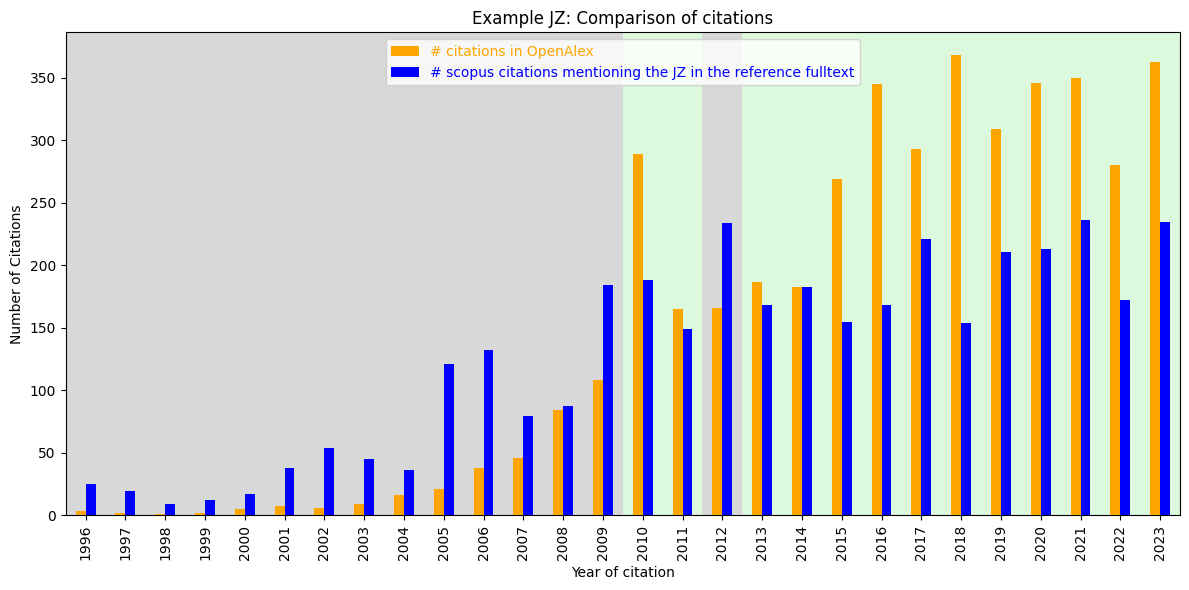

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Angenommen, Ihr DataFrame heißt 'df'
# df = pd.DataFrame(...)

# Farben definieren
color_openalex = 'orange'
color_scopus = 'blue'

# Erstellen des Balkendiagramms
fig, ax = plt.subplots(figsize=(12, 6))

# Hintergrundfarbe setzen
for i, (index, row) in enumerate(df.iterrows()):
    if row['cits_openalex'] >= row['cits_on_jz_scp']:
        ax.axvspan(i-0.5, i+0.5, facecolor='lightgreen', alpha=0.3, zorder=0)
    else:
        ax.axvspan(i-0.5, i+0.5, facecolor='grey', alpha=0.3, zorder=0)

# Balken zeichnen
bars = df.plot.bar(x='citing_pubyear', y=['cits_openalex', 'cits_on_jz_scp'], 
                   color=[color_openalex, color_scopus], ax=ax, zorder=3)

# Anpassen der Legende
legend_labels = ['# citations in OpenAlex', '# scopus citations mentioning the JZ in the reference fulltext']
plt.legend(bars.containers, legend_labels, labelcolor=[color_openalex, color_scopus])

# Beschriftungen hinzufügen
plt.xlabel('Year of citation')
plt.ylabel('Number of Citations')
plt.title('Example JZ: Comparison of citations')

# Diagramm anzeigen
plt.tight_layout()
plt.show()


## <a id="classifications"></a> Classification in OpenAlex

### <a id="keywords"></a> Keywords

Which keywords were assigned to the articles from the goldstandard journals? 
We use display_name of works.keywords: There are up to 5 keywords based on topics, threshold is already taken into account, 
openalex documentation: https://docs.openalex.org/api-entities/keywords#display_name

Topics documentation OpenAlex: https://docs.openalex.org/api-entities/works/work-object#topics

In [129]:
%%sql
drop table if exists {{result_schema}}.eva_keywords_for_articles_in_goldstandard_{{version_name}};
create table {{result_schema}}.eva_keywords_for_articles_in_goldstandard_{{version_name}} as (
select keyword, count(distinct item_id) as item_cnt
from 
(
select b.item_id, unnest(b.keyword) as keyword 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} a 
join {{openalex_bdb_schema}}.items b 
on a.item_id = b.item_id
)
group by keyword
order by count(*) desc); 

Running query in 'kb_prod'

3877 rows affected.

++
||
++
++

In [4]:
%%sql
select * 
from {{result_schema}}.eva_keywords_for_articles_in_goldstandard_{{version_name}} 
order by item_cnt desc

Running query in 'kb_prod'

3877 rows affected.

keyword,item_cnt
Legal Methodology,8152
Informed Consent,4172
European Law,4001
Privacy,2915
Constitutional Courts,2880
Human Rights,2866
Legal History,2755
Criminal Law,2525
Participation,2394
Company Governance,2092


In [11]:
df = pd.read_sql(f'''select * 
from {result_schema}.eva_keywords_for_articles_in_goldstandard_{version_name}
order by item_cnt desc''',engine)

keword word cloud

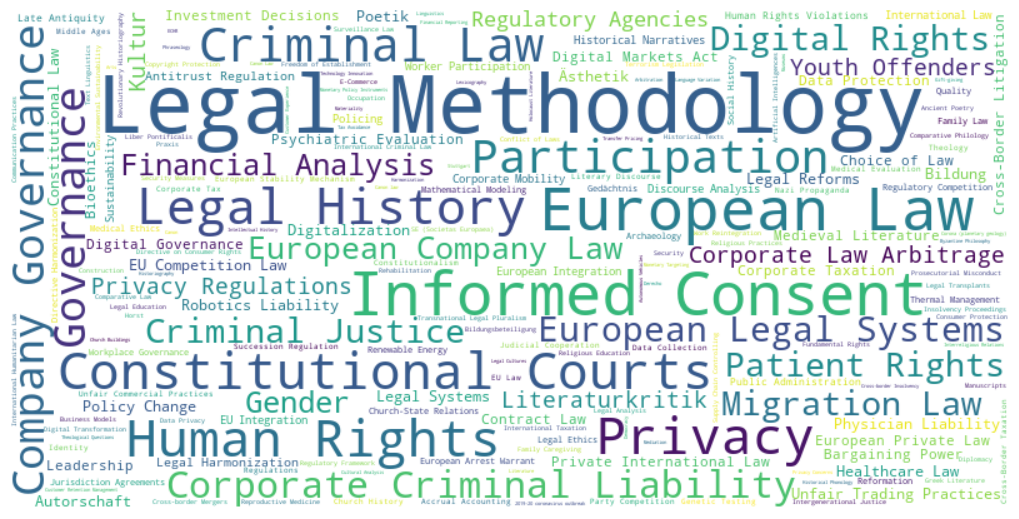

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq = dict(zip(df['keyword'], df['item_cnt']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## <a id="rankings"></a> Rankings: Journal impact factor and citations per paper

Function to calculate the journal impact factor. 

In [144]:
%%sql
CREATE OR REPLACE FUNCTION {{result_schema}}.jif(abk text, py integer)
 RETURNS decimal
 LANGUAGE plpgsql
AS $function$
DECLARE
    result decimal;
	cnt_items integer;
	cnt_refs integer;
    query_cnt_items TEXT;
	query_cnt_refs text;
BEGIN


    query_cnt_items := format('SELECT COUNT(distinct item_id) 
				from {{result_schema}}.eva_all_openalex_items_{{version_name}} a 
				WHERE abk = $1 and (pubyear = $2 - 1 or pubyear = $2 +1)');
	
	execute query_cnt_items into cnt_items using abk, py;


	query_cnt_refs := format('select count(distinct b.work_id) as cnt_citations 
			from {{result_schema}}.eva_all_openalex_items_{{version_name}} a
			join {{openalex_rep_schema}}.works_referenced_works b
			on a.item_id = b.referenced_work_id 
			join {{openalex_rep_schema}}.works c 
			on b.work_id = c.id 
			where abk = $2 and (a.pubyear = $3 -1 or a.pubyear = $3 -2) and c.publication_year=$3
			');

	execute query_cnt_refs into cnt_refs using cnt_items, abk, py;

	if cnt_items = 0 then result := NULL; 
	else 
		result := round(cnt_refs/cnt_items::decimal,2);
	end if;

    RETURN result;
END;
$function$
;

Running query in 'kb_prod'

++
||
++
++

Table with journal impact factor for publication years from 2000. 

In [145]:
%%sql
drop table if exists {{result_schema}}.eva_journal_impact_factors_{{version_name}};
create table {{result_schema}}.eva_journal_impact_factors_{{version_name}} as (
select abk, pubyear, {{result_schema}}.jif(abk, pubyear) as journal_impact_factor
from 
(select distinct abk, pubyear 
from {{result_schema}}.eva_all_openalex_items_{{version_name}} a 
where pubyear >= 2000 and pubyear > (
select min_pubyear_in_openalex 
from {{result_schema}}.eva_all_journals_{{version_name}} eaj 
where abk = a.abk) 
order by abk, pubyear)
order by abk, pubyear);

Running query in 'kb_prod'

594 rows affected.

++
||
++
++

### <a id="ranking_comparisons"></a> Ranking comparisons

Comparison for general law journals: ranking with journal impact factor 2009 (because this is the publication year of the Gröls article) vs ranking frpm Gröls article. 
For other publication years change the parameter below.

In [155]:
jif_year = 2009

In [156]:
%%sql
select a.abk, a.openalex_source_id,  
a.rang as rank_article,  
journal_impact_factor,
rank_with_jif_2009 
from {{result_schema}}.jura_groels_tabelle1_allg_zeitschriften a 
left join (
select abk, journal_impact_factor,  
RANK() OVER (ORDER BY journal_impact_factor DESC) as rank_with_jif_2009 
from (select * from {{result_schema}}.eva_journal_impact_factors_{{version_name}} 
where journal_impact_factor is not null and pubyear = {{jif_year}} 
and abk in (select abk from {{result_schema}}.jura_groels_tabelle1_allg_zeitschriften))
) b 
on a.abk = b.abk 
order by a.rang 

Running query in 'kb_prod'

18 rows affected.

abk,openalex_source_id,rank_article,journal_impact_factor,rank_with_jif_2009
JZ,S157638965,1,0.06,5
NJW,"S4306520736,S4363605508",2,None,None
AcP,S82779185,3,0.07,3
AöR,S78787406,4,0.05,6
JuS,"S4306516541,S4306517198",5,0.00,11
JURA,"S4210240061,S100217200",6,None,None
JR,S25774322,7,0.03,7
Staat,S204358660,8,0.13,1
MDR,"S4210169614,S4306520172",9,0.00,11
JA,-,10,None,None


Use an average journal impact factor (publication year >= 2000)

In [157]:
%%sql
select a.abk, a.openalex_source_id, 
a.rang as rank_article,  
journal_impact_factor,
rank_with_avg_jif
from {{result_schema}}.jura_groels_tabelle1_allg_zeitschriften a 
left join (
select abk, journal_impact_factor,  
RANK() OVER (ORDER BY journal_impact_factor DESC) as rank_with_avg_jif 
from (select abk, round(avg(journal_impact_factor),2) as journal_impact_factor 
from {{result_schema}}.eva_journal_impact_factors_{{version_name}}  
where journal_impact_factor is not null and pubyear > 2000 
and abk in (select abk from {{result_schema}}.jura_groels_tabelle1_allg_zeitschriften)
group by abk )
) b 
on a.abk = b.abk 
order by a.rang 

Running query in 'kb_prod'

18 rows affected.

abk,openalex_source_id,rank_article,journal_impact_factor,rank_with_avg_jif
JZ,S157638965,1,0.07,6
NJW,"S4306520736,S4363605508",2,None,None
AcP,S82779185,3,0.09,4
AöR,S78787406,4,0.10,3
JuS,"S4306516541,S4306517198",5,0.01,12
JURA,"S4210240061,S100217200",6,0.01,12
JR,S25774322,7,0.05,8
Staat,S204358660,8,0.15,2
MDR,"S4210169614,S4306520172",9,0.00,14
JA,-,10,None,None


Comparison article ranking and citations per paper

In [158]:
%%sql
select a.abk, a.openalex_source_id,  
a.rang as rank_article,  
cpp,
rank_with_cpp 
from {{result_schema}}.jura_groels_tabelle1_allg_zeitschriften a 
left join (
select abk,  
round(sum_citations_for_all_articles_in_openalex/num_articles_in_openalex::decimal,2) AS cpp,
RANK() OVER (ORDER BY round(sum_citations_for_all_articles_in_openalex/num_articles_in_openalex::decimal,2)  desc) as rank_with_cpp
from (select * from {{result_schema}}.eva_all_journals_{{version_name}}  
where num_articles_in_openalex is not null and num_articles_in_openalex > 0 
and abk in (select abk from {{result_schema}}.jura_groels_tabelle1_allg_zeitschriften) 
)) b 
on a.abk = b.abk 
order by a.rang 

Running query in 'kb_prod'

18 rows affected.

abk,openalex_source_id,rank_article,cpp,rank_with_cpp
JZ,S157638965,1,0.65,9
NJW,"S4306520736,S4363605508",2,None,None
AcP,S82779185,3,0.98,6
AöR,S78787406,4,1.32,4
JuS,"S4306516541,S4306517198",5,0.21,12
JURA,"S4210240061,S100217200",6,0.14,13
JR,S25774322,7,0.69,8
Staat,S204358660,8,2.44,1
MDR,"S4210169614,S4306520172",9,0.02,14
JA,-,10,None,None


In [8]:
%%sql
    -- !! todo: löschen bei Veröffentlichung !!
grant select on all tables in schema {{result_schema}} to mpgdfejzo, mpgcboulanger, kbprodadmin;

Running query in 'kb_prod'

++
||
++
++